In [1]:
import numpy as np
import pandas as pd

import astropy.units as u
import astropy.constants as c
from astropy.time import Time
import datetime

In [2]:
"MATPLOTLIB"
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pylab import cm
import matplotlib.lines as lines

mpl.rcParams['font.family'] = 'Latin Modern Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2

In [3]:
def Gain(D,freq):
    lam=c.c/(freq)
    A=np.pi*(D/2)**2
    e=1
    G=4*np.pi*e*A/lam**2 # calculate gain (Eq. A)
    return G.cgs

def power(tx,rx,df,rtdb,dl,sig=0.023*u.km**2,tau=(0.1*u.s).cgs): # from literature
    nametx=rtdb.Name[rtdb.Code==tx].iloc[0] # TX name from code
    namerx=rtdb.Name[rtdb.Code==rx].iloc[0] # RX name from code
    rtx=(df[nametx].to_numpy())*c.R_earth # distance to TX
    rrx=(df[namerx].to_numpy())*c.R_earth # distance to RX
    Dtx=rtdb.Diameter[rtdb.Code==tx].iloc[0]*u.m # TX diameter
    Drx=rtdb.Diameter[rtdb.Code==rx].iloc[0]*u.m # RX diameter
    Tsys=rtdb.Tsys[rtdb.Code==rx].iloc[0]*u.K # system temperature (RX)
    freq=rtdb.Frequency[rtdb.Code==tx].iloc[0]*1e6*u.Hz # transmission freq TX
    Ptx=rtdb.Power[rtdb.Code==tx].iloc[0]*1e3*u.W # transmission power TX
    Gtx=Gain(Dtx,freq) # TX gain
    Grx=Gain(Drx,freq) # RX gain
    Prx=(Ptx*Gtx*Grx*(c.c/(freq))**2*sig/((4*np.pi)**3*rtx**2*rrx**2)).si # calculate Prx (Eq. B)
    PrxdB=10*np.log10((Prx/u.mW).si.value)  #return Prx in dBm
    Pratio=(Prx/Ptx).si  #return TX/RX power ratio

    time=pd.to_datetime(dl.date)
    dt=(time.iloc[1]-time.iloc[0]).total_seconds()*u.s # time increment in dl
    lon=(dl.lonR.to_numpy())*u.deg.to(u.rad) # sub-radar longitude to radians
    lat=(dl.latR.to_numpy())*u.deg.to(u.rad) # sub-radar latitude to radians
    x=np.sin(lat)*np.cos(lon) # unit vector coord x
    y=np.sin(lat)*np.sin(lon) # unit vector coord y
    z=np.cos(lat) # unit vector coord z
    pointing=np.vstack((x,y,z)).T # unit vector of subradar pointing
    dtheta=np.arccos((pointing[1:]*pointing[:-1]).sum(axis=1)) # change in angle from moment to moment
    omega=dtheta/dt # angular frequency
    period=2*np.pi/omega # return rotation period
    rotfreq=1/period # rotation frequency
    phi=lat[1:] # subradar latitude
    bw=4*np.pi*np.cos(phi)*370*u.m/((c.c/freq)*omega) # Doppler bandwidth (Eq. C)
    Nrms=(Tsys*c.k_B*np.sqrt(bw/tau)) # rms noise power (Eq. D)
    SNR=(Prx[1:]/Nrms).si # return signal-to-noise ratio 
    return PrxdB, Pratio, SNR, omega, nametx,namerx

In [4]:
df=pd.read_csv("../Data/observatory_distances_indexes.csv")
rtdb=pd.read_csv('../AllRadiotelescopes.csv')
dl=pd.read_csv('../Data/subradar_points.csv')
elevations = pd.read_csv("../Data/elevations.csv")

ephemeris = pd.read_csv("../ephemeris2.csv")
ephemeris['hours'] = 24*(ephemeris['datetime_jd']-ephemeris['datetime_jd'][0])
MIN = ephemeris['delta (Rt)'].argmin()

In [5]:
print([i for i in rtdb.Code])

['CDS', 'PRK', 'MDS', 'LOV', 'EFE', 'AVN', 'GOL', 'GBT', 'VLA', 'ARE', 'FAS', 'ECD', 'USU']


In [6]:
pairs = [
    ('CDS','PRK'),
    ('MDS','LOV'),
    ('MDS','AVN'),
    ('MDS','EFE'),
    ('GOL','GBT'),
    ('ARE','GBT'),
    ('ECD','FAS'),
    ('USU','FAS'),
]


'lmroman10-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


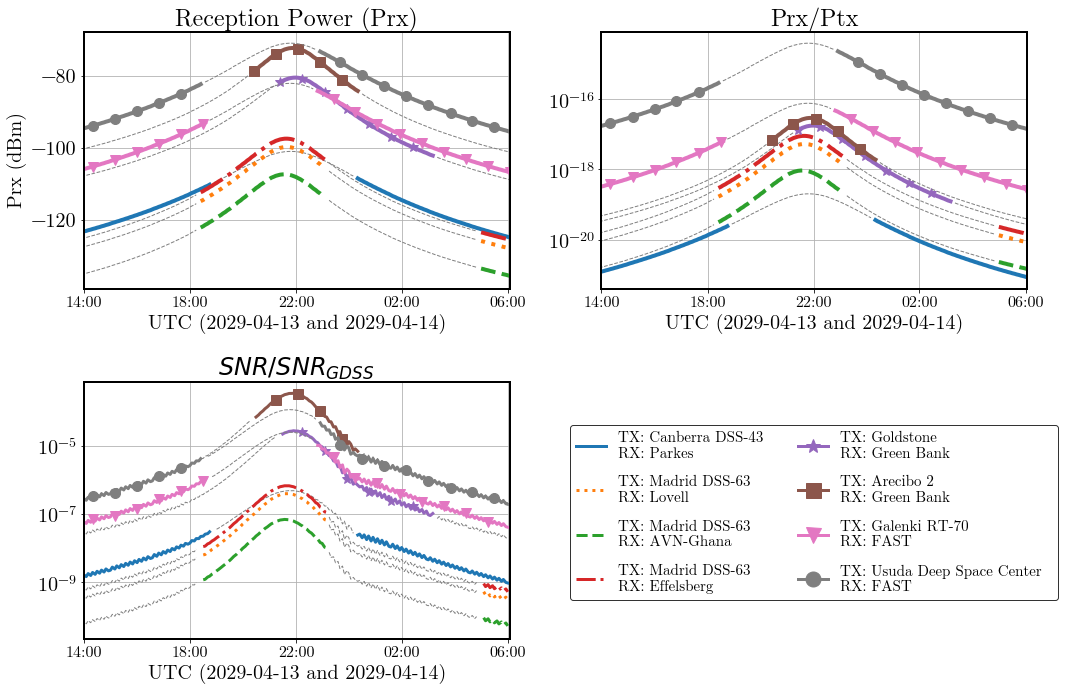

In [7]:
def x_axis(ax,i):
    ax.set_xlim([0,ephemeris['hours'].iloc[-1]])
    xticks = range(6,len(ephemeris),48)
    ax.set_xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    ax.set_xticks([ephemeris['hours'][n] for n in xticks])

    if i != 10:
        ax.set_xticklabels([ephemeris['datetime_str'][i][-5:] for i in xticks],size=16)
        ax.set_xlabel("UTC (2029-04-13 and 2029-04-14)",size=20)
    else:
        ax.set_xticklabels([])


def chop(Ys, cond):
    """
    Removes the parts of an array which correspond to non visible zones
    """
    pm = np.array([a*b for a,b in zip(elevations[tx],elevations[tx][1:])])
    nanwhere = np.where(pm < 0)
    
    Y = Ys
    Y[nanwhere] = np.nan
    Y = Y[cond]
    return Y
    

def all_power_plots(axes,n,PrxdB, Pratio, SNR, nametx,namerx,df,tx,rx):
    title='TX: {} \nRX: {}'.format(nametx,namerx)

    savefigs = False
    styles = ['-',':','--','-.','*-','s-','v-','o-','D-']

    cond = elevations[tx] > 0
    times = ephemeris['hours'][cond]
    timesnt = ephemeris['hours'][~cond]

    Y = chop(PrxdB,cond)
    Ynt = chop(PrxdB,~cond)
    
    i = 0
    ax = axes[i]
    # dBm plot
    ax.plot(times,Y,styles[n],lw=4,markevery=10,ms=10)
    ax.plot(timesnt,Ynt,'--',lw=1,color='gray')
    ax.set_title("Reception Power (Prx)")
    ax.set_ylabel("Prx (dBm)")
    x_axis(ax,i)

    Y = chop(Pratio,cond)
    Ynt = chop(Pratio,~cond)

    i += 1
    ax = axes[i]
    # Power ratio plot
    ax.semilogy(times,Y,styles[n],lw=4,markevery=10,ms=10)
    ax.semilogy(timesnt,Ynt,'--',lw=1,color='gray')
    ax.set_title("Prx/Ptx")
    x_axis(ax,i)


    Y = chop(SNR,cond[1:])
    Ynt = chop(SNR,~cond[1:])
    times = ephemeris['hours'][cond][:-1]
    timesnt = ephemeris['hours'][~cond][:-1]

    Y = Y[:min(len(Y),len(times))]
    times = times[:min(len(Y),len(times))]
    Ynt = Ynt[:min(len(Ynt),len(timesnt))]
    timesnt = timesnt[:min(len(Ynt),len(timesnt))]

    Y0 = 0.8e10

    i += 1
    ax = axes[i]
    # SNR plot
    # ax.semilogy(ephemeris['hours'][1:],SNR,styles[n],lw=3,markevery=10,ms=10)
    ax.semilogy(times,Y/Y0,styles[n],lw=3,markevery=10,ms=10)
    ax.semilogy(timesnt,Ynt/Y0,'--',lw=1,color='gray')
    ax.set_title(r"$SNR / SNR_{GDSS}$")
    x_axis(ax,i)

    i += 1
    ax = axes[i]
    # rotation period plot
    ax.plot([],[],styles[n],lw=3,markevery=10,ms=15,label=title)
    # ax.set_ylabel("Angular frequency (deg/hour)")
    # ax.legend(fontsize=15)
    x_axis(ax,i)


fig, axes = plt.subplots(2,2,figsize=(15,10))

# for ax in axes.flat:
#     ax.set_prop_cycle(plt.cycler('color', plt.cm.nipy_spectral(np.linspace(0.1,0.9,5)**2)))
# fig.suptitle("Reception (rx) and Transmission (tx) Radar Power")

n = 0
for tx, rx in pairs:
    PrxdB, Pratio, SNR, period, nametx,namerx= power(tx,rx,df,rtdb,dl)
    all_power_plots(axes.flat, n, PrxdB, Pratio, SNR, nametx, namerx, df, tx, rx)
    n += 1

for ax in axes.flat:
    ax.grid()

handles, labels = axes.flat[-1].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.5, -0.1, 0.5, 0.5), fontsize=15, labelspacing=1, fancybox=True, edgecolor=(0,0,0))
fig.delaxes(axes.flat[-1])
# fig.delaxes(axes.flat[-3])
fig.tight_layout()

name = "../Figures/fig6_radio"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

'lmroman10-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


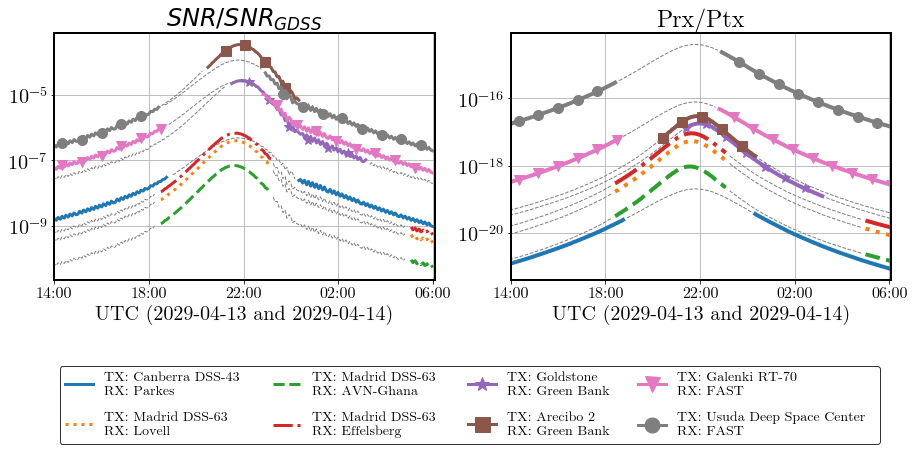

In [8]:
def x_axis(ax,i):
    ax.set_xlim([0,ephemeris['hours'].iloc[-1]])
    xticks = range(6,len(ephemeris),48)
    ax.set_xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    ax.set_xticks([ephemeris['hours'][n] for n in xticks])

    if i != 10:
        ax.set_xticklabels([ephemeris['datetime_str'][i][-5:] for i in xticks],size=16)
        ax.set_xlabel("UTC (2029-04-13 and 2029-04-14)",size=20)
    else:
        ax.set_xticklabels([])


def chop(Ys, cond):
    """
    Removes the parts of an array which correspond to non visible zones
    """
    pm = np.array([a*b for a,b in zip(elevations[tx],elevations[tx][1:])])
    nanwhere = np.where(pm < 0)
    
    Y = Ys
    Y[nanwhere] = np.nan
    Y = Y[cond]
    return Y
    

def all_power_plots(axes,n,PrxdB, Pratio, SNR, nametx,namerx,df,tx,rx):
    title='TX: {} \nRX: {}'.format(nametx,namerx)

    savefigs = False
    styles = ['-',':','--','-.','*-','s-','v-','o-','D-']

    cond = elevations[tx] > 0

    Y = chop(PrxdB,cond)
    Ynt = chop(PrxdB,~cond)
    
    i = 0
    Y = chop(SNR,cond[1:])
    Ynt = chop(SNR,~cond[1:])
    times = ephemeris['hours'][cond][:-1]
    timesnt = ephemeris['hours'][~cond][:-1]

    Y = Y[:min(len(Y),len(times))]
    times = times[:min(len(Y),len(times))]
    Ynt = Ynt[:min(len(Ynt),len(timesnt))]
    timesnt = timesnt[:min(len(Ynt),len(timesnt))]

    Y0 = 0.8e10

    ax = axes[i]
    # SNR plot
    # ax.semilogy(ephemeris['hours'][1:],SNR,styles[n],lw=3,markevery=10,ms=10)
    ax.semilogy(times,Y/Y0,styles[n],lw=3,markevery=10,ms=10)
    ax.semilogy(timesnt,Ynt/Y0,'--',lw=1,color='gray')
    ax.set_title(r"$SNR / SNR_{GDSS}$")
    x_axis(ax,i)

    Y = chop(Pratio,cond)
    Ynt = chop(Pratio,~cond)

    times = ephemeris['hours'][cond]
    timesnt = ephemeris['hours'][~cond]

    i += 1
    ax = axes[i]
    # Power ratio plot
    ax.semilogy(times,Y,styles[n],lw=4,markevery=10,ms=10)
    ax.semilogy(timesnt,Ynt,'--',lw=1,color='gray')
    ax.set_title("Prx/Ptx")
    x_axis(ax,i)

    i += 1
    ax = axes[i]
    # rotation period plot
    ax.plot([],[],styles[n],lw=3,markevery=10,ms=15,label=title)
    # ax.set_ylabel("Angular frequency (deg/hour)")
    # ax.legend(fontsize=15)
    x_axis(ax,i)

    i += 1
    ax = axes[i]
    # rotation period plot
    ax.plot([],[],styles[n],lw=3,markevery=10,ms=15,label=title)
    # ax.set_ylabel("Angular frequency (deg/hour)")
    # ax.legend(fontsize=15)
    x_axis(ax,i)


fig, axes = plt.subplots(2,2,figsize=(15,10))

# for ax in axes.flat:
#     ax.set_prop_cycle(plt.cycler('color', plt.cm.nipy_spectral(np.linspace(0.1,0.9,5)**2)))
# fig.suptitle("Reception (rx) and Transmission (tx) Radar Power")

n = 0
for tx, rx in pairs:
    PrxdB, Pratio, SNR, period, nametx,namerx= power(tx,rx,df,rtdb,dl)
    all_power_plots(axes.flat, n, PrxdB, Pratio, SNR, nametx, namerx, df, tx, rx)
    n += 1

for ax in axes.flat:
    ax.grid()

handles, labels = axes.flat[-1].get_legend_handles_labels()
fig.legend(handles, labels, ncol=4, loc = "lower center",
            fontsize=14, labelspacing=1, fancybox=True, 
            edgecolor=(0,0,0), bbox_to_anchor=(0.26, 0.3, 0.5, 0.5))
fig.delaxes(axes.flat[-1])
fig.delaxes(axes.flat[-2])
# fig.tight_layout()

name = "../Figures/fig6_radio"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

# Doppler Shift

In [9]:
vectors = pd.read_csv("../Data/vectors2.csv")

In [10]:
V = (np.array((vectors.vx,vectors.vy,vectors.vz))*(u.AU/u.d)).si
R = (np.array((vectors.x,vectors.y,vectors.z))*(u.AU)).si
R1 = R/np.linalg.norm(R, axis=0)
# plt.plot(np.linalg.norm(V, axis=0))

In [11]:
# Given longitude and latitude angles in degrees, return cartesian representation
spherical = lambda lon,lat: (np.cos(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                             np.sin(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                             np.sin(np.deg2rad(lat)))

sphericalV = lambda lon,lat: (np.sin(np.deg2rad(lon))*np.cos(np.deg2rad(lat))*-1,
                              np.cos(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                              0*lon)

norm = np.linalg.norm


def get_RA(TIME,LON):
  """
  Gets the longitude that will be under the asteroid at every moment
  """
  T = Time(TIME,format='jd')
  G = T.sidereal_time('apparent', 'greenwich').to(u.deg)
  return LON + G.value

import warnings
warnings.filterwarnings("ignore")

def get_dVr(obs):
    """
    Calculates the radial velocity between the asteroid and rotating earth
    """
    lon,lat = obs[['Longitude','Latitude']] # TX name from code
    RAs = get_RA(ephemeris.datetime_jd,lon)

    V_earth = (2*np.pi*c.R_earth/u.d)

    dV = (V - (sphericalV(RAs,lat)*V_earth).si)

    dVr = ddot(dV,R1)
    return dVr

def ddot(V1,V2):
    V3 = np.zeros_like(V1)
    for i in range(V3.shape[1]):
        V3[:,i] = np.dot(V1[:,i],V2[:,i])
    return norm(V3,axis=0)


def get_veph(code1,code2):
    """
    Calculates de Doppler Frequency Shift
    """
    obs1 = rtdb[rtdb.Code==code1].iloc[0]
    obs2 = rtdb[rtdb.Code==code2].iloc[0]

    F = obs1['Frequency']*1e6*u.Hz

    dVr1 = get_dVr(obs1)
    dVr2 = get_dVr(obs2)

    return F*dVr1*dVr2/(c.c**2)

'lmroman10-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


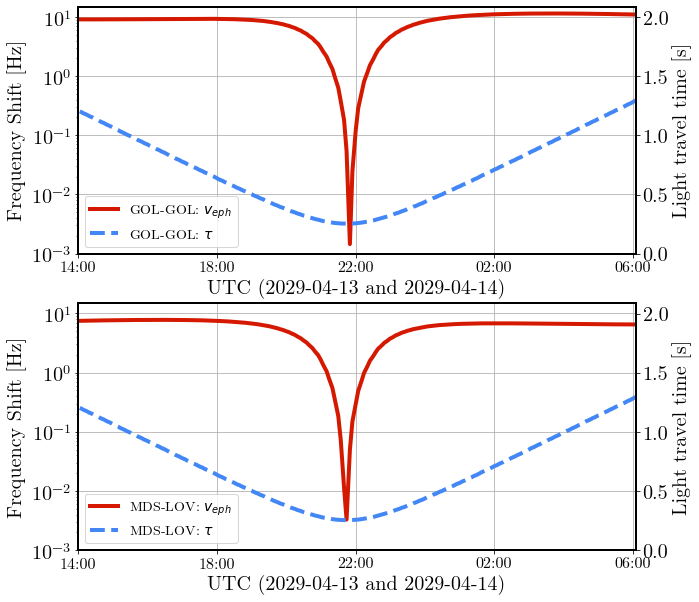

In [12]:
plt.figure(figsize=(10,10))

pairs2 = [
    ('GOL','GOL'),
    ('MDS','LOV'),
]

k = 1
for pair in pairs2:
    if k == 1:
        plt.title("Doppler Frequency Shift \nand Time of flight")
    veph = get_veph(*pair)
    plt.subplot(2,1,k)
    ax = plt.gca()
    lns1 = ax.semilogy(ephemeris['hours'],veph,label="-".join(pair) + r": $v_{eph}$",lw=4, color='#d41900')
    x_axis(ax,k)
    ax.set_ylabel("Frequency Shift [Hz]")
    ax.set_ylim([1e-3,1.5e1])
    ax.grid()
    ax2=plt.gca().twinx()
    lns2 = ax2.plot(ephemeris['hours'],2*ephemeris['delta (Rt)'] * c.R_earth / c.c, '--',
        label="-".join(pair) + r": $\tau$", lw=4, color='#4287f5')
    ax2.set_ylim([0,2.09])
    ax2.set_ylabel("Light travel time [s]")

    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs,fontsize=14)
    k += 1


name = "../Figures/fig13_veph"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

# Rotation

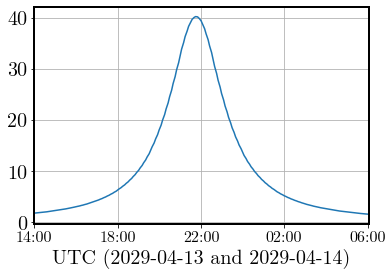

In [13]:
e = R1
e_dot = V/norm(R,axis=0) -  (norm(ddot(V,R1),axis=0)*R/(norm(R, axis=0)**2))
Wsky = np.cross(e,e_dot,axis=0).to(1/u.h)*180*u.deg/np.pi
plt.plot(ephemeris['hours'],norm(Wsky,axis=0))
plt.grid()
x_axis(plt.gca(),0)

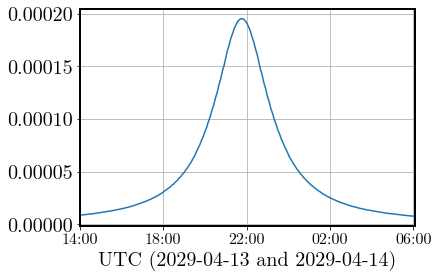

In [14]:
e = R1
e_dot = V/norm(R,axis=0) - (ddot(V,R1)*R/(norm(R, axis=0)**2))
Wsky = np.cross(e_dot,e,axis=0).to(1/u.h)*180*u.deg/np.pi
plt.plot(ephemeris['hours'],norm(np.cross(e,e_dot,axis=0),axis=0))
plt.grid()
x_axis(plt.gca(),0)

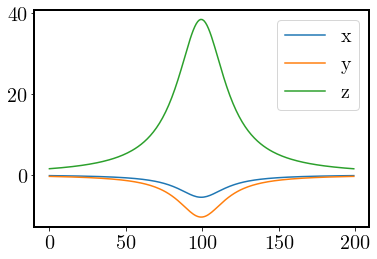

In [15]:
for i,w in enumerate(Wsky):
    plt.plot(w,label=list('xyz')[i])
plt.legend()

'lmroman10-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


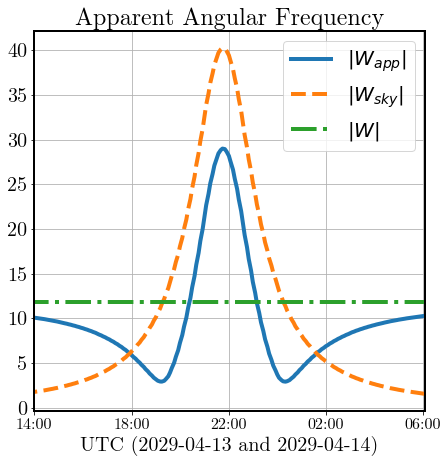

In [16]:
W = spherical(118.8,-79.4)*(360*u.deg/(30.56*u.h))

WW = np.ones_like(Wsky)
for i in range(WW.shape[1]):
    WW[:,i] = W


plt.figure(figsize=(7,7))
plt.plot(ephemeris['hours'],norm(WW+Wsky,axis=0),lw=4,label=r"$|W_{app}|$")
plt.plot(ephemeris['hours'],norm(Wsky,axis=0),'--',lw=4,label=r"$|W_{sky}|$")
plt.plot(ephemeris['hours'],norm(WW,axis=0),'-.',lw=4,label=r"$|W|$")
plt.grid()
plt.legend()
x_axis(plt.gca(),0)
plt.title("Apparent Angular Frequency")

name = "../Figures/fig8_rotations"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

In [17]:
Wapp = norm(WW+Wsky,axis=0)
Wapp.value

array([10.27062183, 10.24215073, 10.21286992, 10.18274874, 10.15175509,
       10.11985533, 10.08701423, 10.05319486, 10.01835849,  9.98246451,
        9.94547028,  9.90733107,  9.86799988,  9.82742734,  9.78556159,
        9.74234806,  9.69772938,  9.6516452 ,  9.60403196,  9.55482276,
        9.50394712,  9.45133077,  9.3968954 ,  9.34055847,  9.28223287,
        9.22182668,  9.1592429 ,  9.09437907,  9.027127  ,  8.95737239,
        8.88499445,  8.80986553,  8.73185072,  8.6508074 ,  8.56658482,
        8.47902365,  8.38795552,  8.29320255,  8.19457693,  8.09188046,
        7.98490416,  7.87342795,  7.75722038,  7.63603852,  7.50962802,
        7.37772341,  7.24004874,  7.09631873,  6.94624059,  6.78951664,
        6.62584827,  6.45494158,  6.27651528,  6.090312  ,  5.89611405,
        5.69376569,  5.48320463,  5.26450668,  5.03794954,  4.80410457,
        4.56396939,  4.31916041,  4.07219205,  3.82687721,  3.58888534,
        3.36646913,  3.1712742 ,  3.01890366,  2.92850507,  2.92

In [18]:
WWW = norm(WW,axis=0)

In [19]:
def Gain(D,freq):
    lam=c.c/(freq)
    A=np.pi*(D/2)**2
    e=1
    G=4*np.pi*e*A/lam**2 # calculate gain (Eq. A)
    return G.cgs

def power(tx,rx,df,rtdb,dl,sig=0.023*u.km**2,tau=(0.1*u.s).cgs): # from literature
    nametx=rtdb.Name[rtdb.Code==tx].iloc[0] # TX name from code
    namerx=rtdb.Name[rtdb.Code==rx].iloc[0] # RX name from code
    rtx=(df[nametx].to_numpy())*c.R_earth # distance to TX
    rrx=(df[namerx].to_numpy())*c.R_earth # distance to RX
    Dtx=rtdb.Diameter[rtdb.Code==tx].iloc[0]*u.m # TX diameter
    Drx=rtdb.Diameter[rtdb.Code==rx].iloc[0]*u.m # RX diameter
    Tsys=rtdb.Tsys[rtdb.Code==rx].iloc[0]*u.K # system temperature (RX)
    freq=rtdb.Frequency[rtdb.Code==tx].iloc[0]*1e6*u.Hz # transmission freq TX
    Ptx=rtdb.Power[rtdb.Code==tx].iloc[0]*1e3*u.W # transmission power TX
    Gtx=Gain(Dtx,freq) # TX gain
    Grx=Gain(Drx,freq) # RX gain
    Prx=(Ptx*Gtx*Grx*(c.c/(freq))**2*sig/((4*np.pi)**3*rtx**2*rrx**2)).si # calculate Prx (Eq. B)
    PrxdB=10*np.log10((Prx/u.mW).si.value)  #return Prx in dBm
    Pratio=(Prx/Ptx).si  #return TX/RX power ratio

    SNRS = []

    lat=(dl.latR.to_numpy())*u.deg.to(u.rad) # sub-radar latitude to radians
    omega=(Wapp.to(u.rad/u.s)) # dtheta/dt # angular frequency
    period=2*np.pi*u.rad/omega # return rotation period
    phi=lat # subradar latitude
    bw=4*np.pi*np.cos(phi)*370*u.m*omega/((c.c/freq)) # Doppler bandwidth (Eq. C)
    Nrms=(Tsys*c.k_B*np.sqrt(bw/tau)) # rms noise power (Eq. D)
    SNR=(Prx/Nrms).si # return signal-to-noise ratio
    SNRS.append(SNR)

    lat=(dl.latR.to_numpy())*u.deg.to(u.rad) # sub-radar latitude to radians
    omega=(WWW.to(u.rad/u.s)) # dtheta/dt # angular frequency
    period=2*np.pi*u.rad/omega # return rotation period
    phi=lat # subradar latitude
    bw=4*np.pi*np.cos(phi)*370*u.m*omega/((c.c/freq)) # Doppler bandwidth (Eq. C)
    Nrms=(Tsys*c.k_B*np.sqrt(bw/tau)) # rms noise power (Eq. D)
    SNR=(Prx/Nrms).si # return signal-to-noise ratio
    SNRS.append(SNR)

    return PrxdB, Pratio, SNRS, omega, nametx,namerx

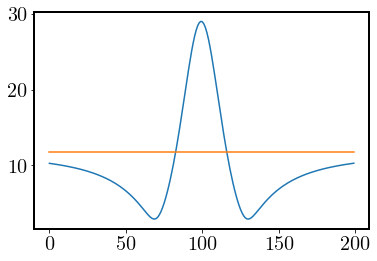

In [20]:
plt.plot(Wapp)
plt.plot(WWW)

In [21]:
pairs

[('CDS', 'PRK'),
 ('MDS', 'LOV'),
 ('MDS', 'AVN'),
 ('MDS', 'EFE'),
 ('GOL', 'GBT'),
 ('ARE', 'GBT'),
 ('ECD', 'FAS'),
 ('USU', 'FAS')]

2013173208.989233 1 / rad(1/2)


'lmroman10-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


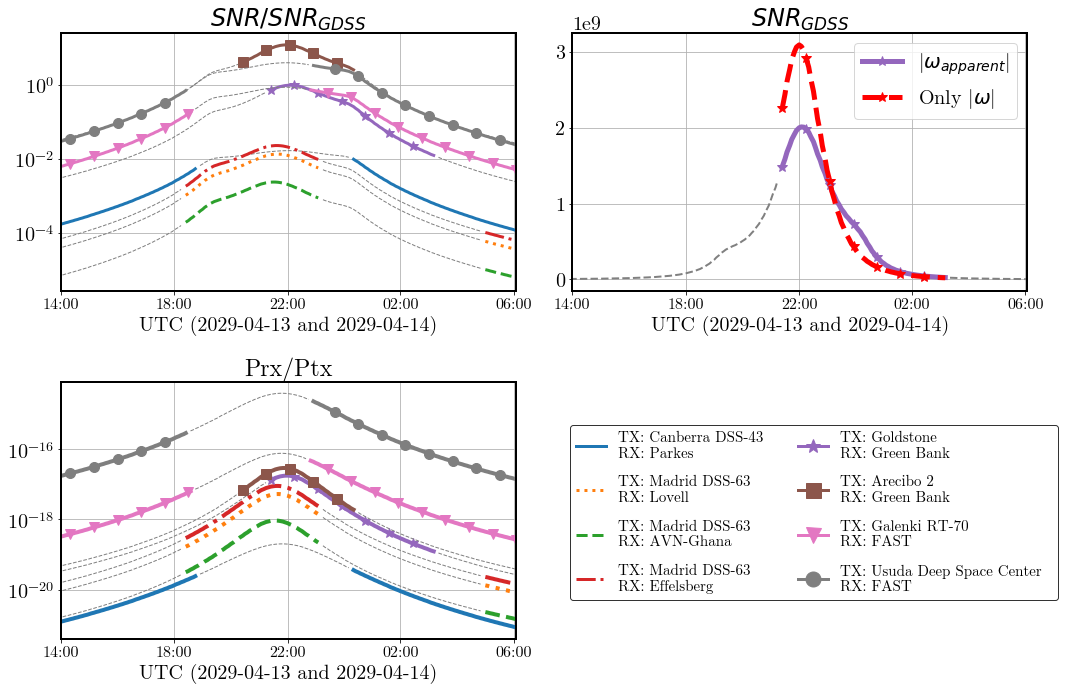

In [26]:
def x_axis(ax,i):
    ax.set_xlim([0,ephemeris['hours'].iloc[-1]])
    xticks = range(6,len(ephemeris),48)
    ax.set_xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    ax.set_xticks([ephemeris['hours'][n] for n in xticks])

    if i != 10:
        ax.set_xticklabels([ephemeris['datetime_str'][i][-5:] for i in xticks],size=16)
        ax.set_xlabel("UTC (2029-04-13 and 2029-04-14)",size=20)
    else:
        ax.set_xticklabels([])


def chop(Ys, cond):
    """
    Removes the parts of an array which correspond to non visible zones
    """
    pm = np.array([a*b for a,b in zip(elevations[tx],elevations[tx][1:])])
    nanwhere = np.where(pm < 0)
    
    Y = Ys
    Y[nanwhere] = np.nan
    Y = Y[cond]
    return Y
    

def all_power_plots(axes,n,PrxdB, Pratio, SNR, nametx,namerx,df,tx,rx):
    title='TX: {} \nRX: {}'.format(nametx,namerx)

    savefigs = False
    styles = ['-',':','--','-.','*-','s-','v-','o-','D-']

    cond = elevations[tx] > 0
    times = ephemeris['hours'][cond]
    timesnt = ephemeris['hours'][~cond]

    Y = chop(PrxdB,cond)
    Ynt = chop(PrxdB,~cond)
    
    i = 0
    ax = axes[i]

    # SNR plot
    SNR,SNR2 = SNR
    Y = chop(SNR,cond)
    Ynt = chop(SNR,~cond)
    Y0 = 2013173208
    # ax.semilogy(ephemeris['hours'],SNR,styles[n],lw=3,markevery=10,ms=10)
    ax.semilogy(times,Y/Y0,styles[n],lw=3,markevery=10,ms=10)
    ax.semilogy(timesnt,Ynt/Y0,'--',lw=1,color='gray')
    ax.set_title(r"$SNR / SNR_{GDSS}$")
    x_axis(ax,i)

    i += 1
    ax = axes[i]
    if tx == 'GOL':
        Y2 = chop(SNR2,cond)
        ax.plot(times,Y,styles[n],lw=5,markevery=10,ms=10,label="|$\omega_{apparent}$|")
        ax.plot(times,Y2,'*--',lw=5,markevery=10,ms=10,color='red',label=r"Only |$\omega$|")
        ax.plot(timesnt,Ynt,'--',lw=2,color='gray')
        ax.set_title(r"$SNR_{GDSS}$")
        ax.legend()
        x_axis(ax,i)
        print(max(Y))
    else:
        ax.plot([],[],styles[n],lw=3,markevery=10,ms=15)

    i += 1
    ax = axes[i]

    # Power ratio plot
    Y = chop(Pratio,cond)
    Ynt = chop(Pratio,~cond)
    ax.semilogy(times,Y,styles[n],lw=4,markevery=10,ms=10)
    ax.semilogy(timesnt,Ynt,'--',lw=1,color='gray')
    ax.set_title("Prx/Ptx")
    x_axis(ax,i)


    i += 1
    ax = axes[i]
    # rotation period plot
    ax.plot([],[],styles[n],lw=3,markevery=10,ms=15,label=title)
    # ax.set_ylabel("Angular frequency (deg/hour)")
    # ax.legend(fontsize=15)
    x_axis(ax,i)


fig, axes = plt.subplots(2,2,figsize=(15,10))

# for ax in axes.flat:
#     ax.set_prop_cycle(plt.cycler('color', plt.cm.nipy_spectral(np.linspace(0.1,0.9,5)**2)))
# fig.suptitle("Reception (rx) and Transmission (tx) Radar Power")

n = 0
for tx, rx in pairs:
    PrxdB, Pratio, SNR, period, nametx,namerx= power(tx,rx,df,rtdb,dl)
    all_power_plots(axes.flat, n, PrxdB, Pratio, SNR, nametx, namerx, df, tx, rx)
    n += 1

for ax in axes.flat:
    ax.grid()

handles, labels = axes.flat[-1].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.5, -0.1, 0.5, 0.5), fontsize=15, labelspacing=1, fancybox=True, edgecolor=(0,0,0))
fig.delaxes(axes.flat[-1])
# fig.delaxes(axes.flat[-3])
fig.tight_layout()

name = "../Figures/fig6_radio"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

In [23]:
SNR[0]

<Quantity [4.81338646e+07, 5.00673656e+07, 5.20980790e+07, 5.42493260e+07,
           5.64927778e+07, 5.88700493e+07, 6.13531831e+07, 6.39852030e+07,
           6.67390058e+07, 6.96588309e+07, 7.27190407e+07, 7.59648320e+07,
           7.93727945e+07, 8.29887336e+07, 8.67924328e+07, 9.08298531e+07,
           9.50851592e+07, 9.96038966e+07, 1.04376102e+08, 1.09435227e+08,
           1.14811848e+08, 1.20507892e+08, 1.26564803e+08, 1.32995834e+08,
           1.39838581e+08, 1.47120825e+08, 1.54874718e+08, 1.63146571e+08,
           1.71961107e+08, 1.81388181e+08, 1.91442638e+08, 2.02224173e+08,
           2.13734753e+08, 2.26111842e+08, 2.39340856e+08, 2.53607068e+08,
           2.68874875e+08, 2.85390138e+08, 3.03197482e+08, 3.22299720e+08,
           3.43064008e+08, 3.65378148e+08, 3.89719940e+08, 4.15932509e+08,
           4.44635632e+08, 4.75618199e+08, 5.09683327e+08, 5.46554962e+08,
           5.87274839e+08, 6.31490593e+08, 6.80557292e+08, 7.34035356e+08,
           7.93695569e+08